# Mice sleep

## Data reading

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.utils import resample



In [13]:
# The file is made up of the following structure:
# state : char (1 byte)
# bin : array[0..400] of single (array of 401 floats (4 bytes each))
# EEGv,EMGv,temp : single (4 bytes each)
# Make a pandas dataframe with the data with appropriate column names
# Create a dtype with the binary data format and the desired column names

# Read all the .smo files in the data folder
train_files = glob.glob('data/*.smo')
test_files = glob.glob('data/test/*.smo')

state_mapping = {
    b'w': 'w', b'1': 'w', b'4': 'w',
    b'n': 'n', b'2': 'n', b'5': 'n',
    b'r': 'r', b'3': 'r', b'6': 'r'
}


def fix_state(dataframe):
    dataframe['state'] = dataframe['state'].map(state_mapping)
    # Change state to 'x' if it is not one of the 3 states
    dataframe = dataframe.dropna()
    return dataframe

def load_file(file_path):
    dt = [('state', 'a1')]
    for i in range(401):
        dt.append(('bin' + str(i), 'f4'))
    dt.append(('EEGv', 'f4'))
    dt.append(('EMGv', 'f4'))
    dt.append(('temp', 'f4'))
    dt = np.dtype(dt)
    data = np.fromfile(file_path, dtype=dt)
    #data = np.fromfile(files[0], dtype=dt)
    df = pd.DataFrame.from_records(data)
    fix_state(df)
    # Keep only the first 2 out of 4 days of data
    df = df[:int(len(df)/2)]
    return df

def load_files(files):
    dt = [('state', 'a1')]
    for i in range(401):
        dt.append(('bin' + str(i), 'f4'))
    dt.append(('EEGv', 'f4'))
    dt.append(('EMGv', 'f4'))
    dt.append(('temp', 'f4'))
    dt = np.dtype(dt)
    data = np.concatenate( [np.fromfile(file, dtype=dt) for file in files] )
    #data = np.fromfile(files[0], dtype=dt)
    df = pd.DataFrame.from_records(data)
    fix_state(df)
    # Keep only the first 2 out of 4 days of data
    df = df[:int(len(df)/2)]
    return df

def balance_classes(df):
    # Get the value counts of each class
    class_counts = df['state'].value_counts()

    # Get the majority class
    minority_class = class_counts.idxmin()

    minority_count = class_counts[minority_class]

    # Get all other classes
    df_balanced = df[df['state'] == minority_class]

    classes = class_counts.index.tolist()
    classes.remove(minority_class)
    for cls in classes:
        df_balanced = pd.concat([df_balanced, df[df['state'] == cls].sample(minority_count)])


    # Combine the oversampled minority classes with the majority class

    return df_balanced


## Separation, Normalization/preprocessing, Feature Selection

# Data Visualization

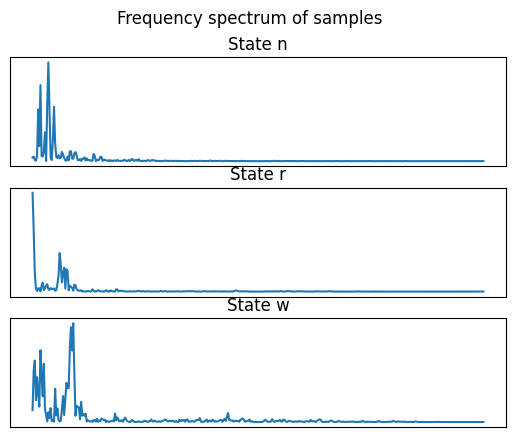

In [14]:
df = load_file(train_files[4])

states = df['state'].unique()
# Pick a sample for each possible state
samples = []
for i in states:
    samples.append(df[df['state'] == i].sample(1))

# Plot the samples frequency spectrum in a grid
# Disable axis numbers and ticks
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
fig, axs = plt.subplots(3, 1)
fig.suptitle('Frequency spectrum of samples')
from itertools import product

subplot_indices = list(product(range(3), range(1)))
for i, sample in enumerate(samples):
    subplot_index = subplot_indices[i]
    axs[subplot_index[0]].plot(sample.iloc[:, 1:401].mean())
    axs[subplot_index[0]].set_title('State ' + str(sample['state'].iloc[0]))
plt.show()




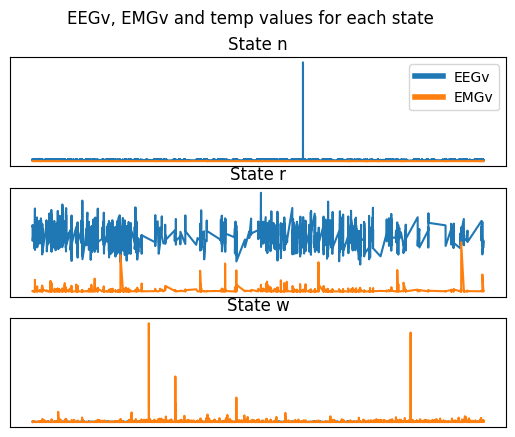

In [15]:
# Plot the possible values for EEGv, EMGv and temp values for each state

# Disable axis numbers and ticks
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
fig, axs = plt.subplots(3, 1)
fig.suptitle('EEGv, EMGv and temp values for each state')
from itertools import product

subplot_indices = list(product(range(3), range(1)))
for i, state in enumerate(states):
    subplot_index = subplot_indices[i]
    axs[subplot_index[0]].plot(df[df['state'] == state]['EEGv'])
    axs[subplot_index[0]].plot(df[df['state'] == state]['EMGv'])
    # Temp is always at 0
    # axs[subplot_index[0], subplot_index[1]].plot(df[df['state'] == state]['temp'])
    axs[subplot_index[0]].set_title('State ' + str(state))

# Add a legend for the colors
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:blue', lw=4),
                Line2D([0], [0], color='tab:orange', lw=4)]
axs[0].legend(custom_lines, ['EEGv', 'EMGv'])


plt.show()




# Normalization

In [16]:
one_hot_mapping = {'w': np.array([0,0,1]),
                 'n': np.array([0,1,0]),
                 'r': np.array([1,0,0])}

def normalize(df):
    normalized_df = balance_classes(df)
    # EEGv
    min_value = df['EEGv'].min()
    max_value = df['EEGv'].max()
    normalized_df['EEGv'] = (df['EEGv'] - min_value) / (max_value - min_value)

    # EMGv
    min_value = df['EMGv'].min()
    max_value = df['EMGv'].max()
    normalized_df['EMGv'] = (df['EMGv'] - min_value) / (max_value - min_value)

    for i in range(401):
        min_value = df['bin' + str(i)].min()
        max_value = df['bin' + str(i)].max()
        normalized_df['bin' + str(i)] = (df['bin' + str(i)] - min_value) / (max_value - min_value)


    # Drop temp column and upper half of bin columns
    normalized_df = normalized_df.drop(['temp'], axis=1)
    normalized_df = normalized_df.drop(normalized_df.iloc[:, 201:401], axis=1)

    # State
    normalized_df['state'] = df['state'].map(one_hot_mapping)

    return normalized_df

def split_data(data):
    return (data.drop('state', axis=1), data['state'])


## Model building

### Model Neural Network

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from keras.optimizers import RMSprop, Adam


def build_model(class_num=3, input_dim=203):
  model = Sequential()
  optimizer = Adam(learning_rate=0.0015)
  model.add(Dense(80, input_dim=input_dim, activation='softmax'))
  model.add(Dense(30, activation='softmax'))
  model.add(Dense(15, activation='softmax'))
  model.add(Dense(10, activation='softmax'))
  model.add(Dropout(0.2))
  model.add(Dense(class_num, activation='softmax'))

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

def save_model(model, model_name):
  model.save(model_name)
  print('Model saved as ' + model_name)

def load_model(model_name):
  model = tf.keras.models.load_model(model_name)
  print('Model loaded from ' + model_name)
  return model

def train_model(model, X_train, y_train, epochs=100, batch_size=10):
  model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

def predict(model, X_test):
  y_pred = model.predict(X_test)
  return y_pred

## Execution

In [18]:
# Get the list of all the files
# Shuffle it
# Pick out 20 files at a time
# Load, normalize, train
# Save the model
# Repeat until all files are used
import random

# Shuffle train_files
training_files = train_files
random.shuffle(training_files)

model = build_model()
save_model(model, 'models/model' + str(0) + '.h5')

# Pick out 20 files at a time
step = 20
for i in range(0, len(training_files), step):
  print("Training with files from " + str(i) + " to " + str(i+step))
  start = i
  end = i+step
  if end > len(training_files):
    end = len(training_files) - 1
  data = load_files(training_files[start:end])
  data = normalize(data)
  data = data.sample(frac=1)
  X_train, y_train = split_data(data)
  print("\tLoaded, Normalized, Split data")
  y_train = np.stack(y_train,axis=0)
  train_model(model, X_train, y_train, epochs=100, batch_size=int(len(X_train)/50))
  save_model(model, 'models/model' + str(i) + '.h5')
  



Model saved as models/model0.h5
Training with files from 0 to 20
	Loaded, Normalized, Split data
Epoch 1/100
51/51 [==============================] - 1s 11ms/step - loss: 1.1003 - accuracy: 0.3328
Epoch 2/100
51/51 [==============================] - 1s 11ms/step - loss: 1.1000 - accuracy: 0.3310
Epoch 3/100
51/51 [==============================] - 1s 11ms/step - loss: 1.0997 - accuracy: 0.3328
Epoch 4/100
51/51 [==============================] - 1s 11ms/step - loss: 1.0998 - accuracy: 0.3335
Epoch 5/100
51/51 [==============================] - 1s 11ms/step - loss: 1.0996 - accuracy: 0.3323
Epoch 6/100
51/51 [==============================] - 1s 11ms/step - loss: 1.0995 - accuracy: 0.3316
Epoch 7/100
51/51 [==============================] - 1s 11ms/step - loss: 1.0994 - accuracy: 0.3338
Epoch 8/100
51/51 [==============================] - 1s 11ms/step - loss: 1.0993 - accuracy: 0.3331
Epoch 9/100
51/51 [==============================] - 1s 11ms/step - loss: 1.0993 - accuracy: 0.3314
Epo

# Evaluation

In [ ]:

loaded_model = load_model('models/model120.h5')

# Test
test_data = load_files(test_files)
test_data = normalize(test_data)
test_data = test_data.sample(frac=1)

X_test, y_test = split_data(test_data)
y_test = np.stack(y_test,axis=0)

# Predict
y_pred = predict(loaded_model, X_test)


Model loaded from models/model120.h5
11011/11011 [==============================] - 11s 918us/step


Test loss: 1.1009334325790405
Test accuracy: 0.3333333432674408
Test F1 score: 0.16666666666666666


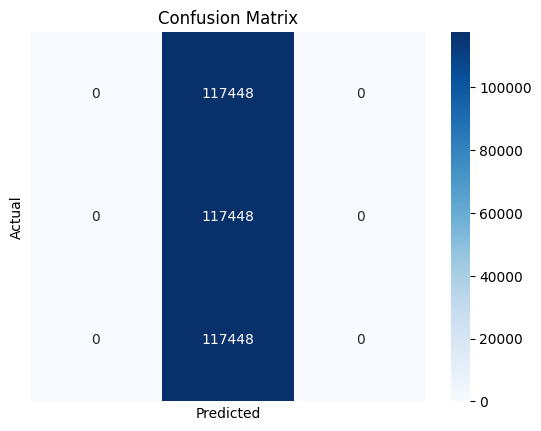

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


prediction = y_pred.argmax(axis=1)
test = y_test.argmax(axis=1)

# Evaluate
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
f1 = f1_score(test, prediction, average='macro')
print('Test F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(test, prediction)

# Create the heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


# Prediction by Genome

In [ ]:
# Group training files by genome

groups = {}

for file in training_files:
  genome = file.split("\\")[-1][0:3]
  if genome not in groups:
    groups[genome] = []
  groups[genome].append(file)

# Pick the N groups with the most files
N = 3
groups = dict(sorted(groups.items(), key=lambda item: len(item[1]), reverse=True)[:N])


for group in groups:
  print(group, ":", len(groups[group]), "mice")


029 : 6 mice
083 : 5 mice
087 : 5 mice


## Training with a single mouse

In [ ]:
models = {}

for group in groups:
  files = groups[group][0:2]
  print("Training with " + files[0] + " " + files[1])
  data = load_files(files)
  data = normalize(data)
  data = data.sample(frac=1)
  X_train, y_train = split_data(data)
  print("\tLoaded, Normalized, and Split data")
  y_train = np.stack(y_train,axis=0)
  print(X_train.shape)
  print(y_train.shape)
  train_model(model, X_train, y_train, epochs=100, batch_size=int(len(X_train)/50))
  print("Genome " + group + " trained")
  models[group] = model
  


Training with data\02909.smo data\02908.smo
	Loaded, Normalized, and Split data
(14346, 203)
(14346, 3)
Epoch 1/100
51/51 [==============================] - 0s 3ms/step - loss: 1.0994 - accuracy: 0.3317
Epoch 2/100
51/51 [==============================] - 0s 3ms/step - loss: 1.0994 - accuracy: 0.3330
Epoch 3/100
51/51 [==============================] - 0s 3ms/step - loss: 1.0993 - accuracy: 0.3370
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0995 - accuracy: 0.3264
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0992 - accuracy: 0.3329
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0994 - accuracy: 0.3383
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0991 - accuracy: 0.3350
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 1.0991 - accuracy: 0.3434
Epoch 9/100
51/51 [==============================] - 0s 3ms/step - loss: 1.0995 - accuracy: 0.3326
Epoch

# Evaluation

{'029': ['data\\02909.smo', 'data\\02908.smo', 'data\\02903.smo', 'data\\02910.smo', 'data\\02901.smo', 'data\\02907.smo'], '083': ['data\\08312.smo', 'data\\08311.smo', 'data\\08305.smo', 'data\\08313.smo', 'data\\08314.smo'], '087': ['data\\08701.smo', 'data\\08710.smo', 'data\\08707.smo', 'data\\08705.smo', 'data\\08706.smo']}
Test loss: 1.6281079053878784
Test accuracy: 0.3337104320526123
1326/1326 [==============================] - 1s 879us/step
[0 1 0]
Test F1 score: 0.16747011426177646


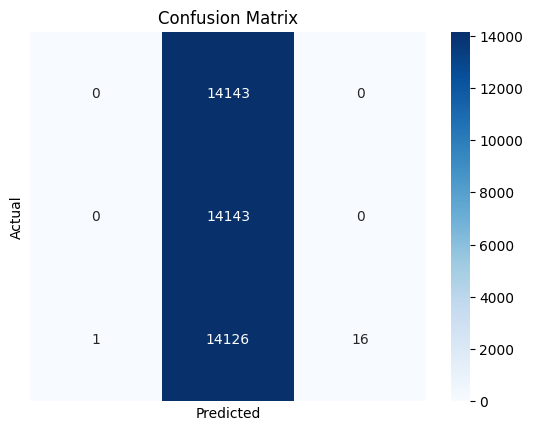

Test loss: 1.623795986175537
Test accuracy: 0.33479443192481995
1091/1091 [==============================] - 1s 819us/step
[0 1 0]
Test F1 score: 0.17011137613035487


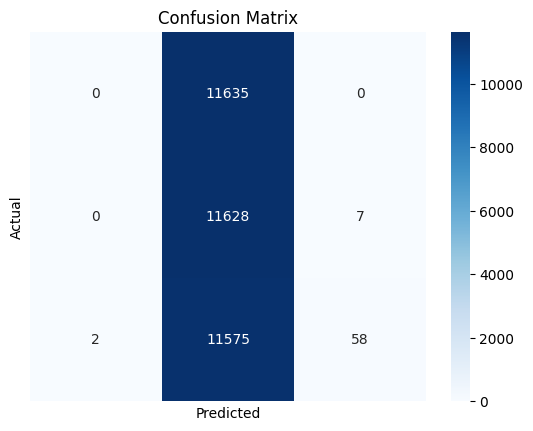

Test loss: 1.630406141281128
Test accuracy: 0.3333861529827118
1184/1184 [==============================] - 1s 877us/step
[0 1 0]
Test F1 score: 0.16678550051120852


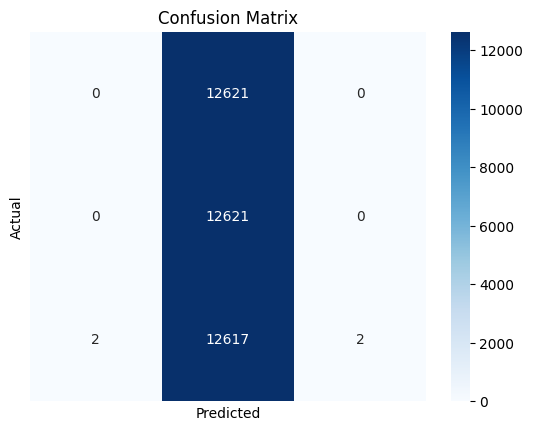

In [ ]:
# Tests have to be on the same genome
# Get the mice from the same genomes

test_groups = {}
for g in groups:
  test_groups[g] = []
  for file in groups[g]:
    genome = file.split("\\")[-1][0:3]
    if genome == g:
      test_groups[g].append(file)

print(test_groups)

for k in models:
  data = load_files(test_groups[k])
  data = normalize(data)
  X_test, y_test = split_data(data)
  y_test = np.stack(y_test,axis=0)
  
  model = models[k]
  score = model.evaluate(X_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  y_pred = predict(model, X_test)
  y_pred = (y_pred > 0.5).astype(int)
  print(y_pred[0])
  f1 = f1_score(y_test, y_pred, average='macro')
  print('Test F1 score:', f1)
  cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
  # Create the heatmap
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
  # Add labels and title
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  # Show the plot
  plt.show()